# Collaboration and Competition

---

In this notebook, you will learn how to use the Unity ML-Agents environment for the third project of the [Deep Reinforcement Learning Nanodegree](https://www.udacity.com/course/deep-reinforcement-learning-nanodegree--nd893) program.

### 1. Start the Environment

We begin by importing the necessary packages.  If the code cell below returns an error, please revisit the project instructions to double-check that you have installed [Unity ML-Agents](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Installation.md) and [NumPy](http://www.numpy.org/).

In [1]:
from unityagents import UnityEnvironment
import numpy as np

Next, we will start the environment!  **_Before running the code cell below_**, change the `file_name` parameter to match the location of the Unity environment that you downloaded.

- **Mac**: `"path/to/Tennis.app"`
- **Windows** (x86): `"path/to/Tennis_Windows_x86/Tennis.exe"`
- **Windows** (x86_64): `"path/to/Tennis_Windows_x86_64/Tennis.exe"`
- **Linux** (x86): `"path/to/Tennis_Linux/Tennis.x86"`
- **Linux** (x86_64): `"path/to/Tennis_Linux/Tennis.x86_64"`
- **Linux** (x86, headless): `"path/to/Tennis_Linux_NoVis/Tennis.x86"`
- **Linux** (x86_64, headless): `"path/to/Tennis_Linux_NoVis/Tennis.x86_64"`

For instance, if you are using a Mac, then you downloaded `Tennis.app`.  If this file is in the same folder as the notebook, then the line below should appear as follows:
```
env = UnityEnvironment(file_name="Tennis.app")
```

In [2]:
env = UnityEnvironment(file_name="../p3_collab-compet/Tennis_Linux/Tennis.x86_64")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 4. It's Your Turn!

Now it's your turn to train your own agent to solve the environment!  When training the environment, set `train_mode=True`, so that the line for resetting the environment looks like the following:
```python
env_info = env.reset(train_mode=True)[brain_name]
```

In [4]:
import random
import copy
from collections import namedtuple, deque
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
# from torch.utils.tensorboard import SummaryWriter
import matplotlib.pyplot as plt




In [5]:
# Define the device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [6]:
class Actor(nn.Module):
    def __init__(self, state_size, action_size, seed, fc1_units=256, fc2_units=128):
        super(Actor, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.fc1 = nn.Linear(state_size, fc1_units)
        self.fc2 = nn.Linear(fc1_units, fc2_units)
        self.fc3 = nn.Linear(fc2_units, action_size)
        self.reset_parameters()

    def reset_parameters(self):
        self.fc1.weight.data.uniform_(*hidden_init(self.fc1))
        self.fc2.weight.data.uniform_(*hidden_init(self.fc2))
        self.fc3.weight.data.uniform_(-3e-3, 3e-3)

    def forward(self, state):
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
        return torch.tanh(self.fc3(x))

In [7]:
class Critic(nn.Module):
    def __init__(self, state_size, action_size, seed, fcs1_units=256, fc2_units=128):
        super(Critic, self).__init__()
        self.seed = torch.manual_seed(seed)
        
        # The input layer expects only the state of the agent
        self.fcs1 = nn.Linear(state_size, fcs1_units)
        
        # The second layer expects the output of the first layer plus the action of the agent
        self.fc2 = nn.Linear(fcs1_units + action_size, fc2_units)
        
        # The output layer produces a single Q-value
        self.fc3 = nn.Linear(fc2_units, 1)
        
        self.reset_parameters()
    
    def reset_parameters(self):
        self.fcs1.weight.data.uniform_(*hidden_init(self.fcs1))
        self.fc2.weight.data.uniform_(*hidden_init(self.fc2))
        self.fc3.weight.data.uniform_(-3e-3, 3e-3)
    
    def forward(self, state, action):
        """Build a critic (value) network that maps (state, action) pairs -> Q-values."""
        xs = F.relu(self.fcs1(state))
        x = torch.cat((xs, action), dim=1)
        x = F.relu(self.fc2(x))
        return self.fc3(x)

def hidden_init(layer):
    fan_in = layer.weight.data.size()[0]
    lim = 1. / np.sqrt(fan_in)
    return (-lim, lim)


In [8]:
class ReplayBuffer:
    def __init__(self, action_size, buffer_size, batch_size, seed):
        self.action_size = action_size
        self.memory = deque(maxlen=buffer_size)
        self.batch_size = batch_size
        self.experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])
        self.seed = random.seed(seed)

    def add(self, state, action, reward, next_state, done):
        e = self.experience(state, action, reward, next_state, done)
        self.memory.append(e)

    def sample(self):
        experiences = random.sample(self.memory, k=self.batch_size)

        states = torch.from_numpy(np.vstack([e.state for e in experiences if e is not None])).float().to(device)
        actions = torch.from_numpy(np.vstack([e.action for e in experiences if e is not None])).float().to(device)
        rewards = torch.from_numpy(np.vstack([e.reward for e in experiences if e is not None])).float().to(device)
        next_states = torch.from_numpy(np.vstack([e.next_state for e in experiences if e is not None])).float().to(device)
        dones = torch.from_numpy(np.vstack([e.done for e in experiences if e is not None]).astype(np.uint8)).float().to(device)

        return (states, actions, rewards, next_states, dones)

    def __len__(self):
        return len(self.memory)


In [9]:
class Agent:
    def __init__(self, state_size, action_size, random_seed):
        self.state_size = state_size
        self.action_size = action_size
        self.seed = random.seed(random_seed)

        # Actor Network (w/ Target Network)
        self.actor_local = Actor(state_size, action_size, random_seed).to(device)
        self.actor_target = Actor(state_size, action_size, random_seed).to(device)
        self.actor_optimizer = optim.Adam(self.actor_local.parameters(), lr=LR_ACTOR)

        # Critic Network (w/ Target Network)
        self.critic_local = Critic(state_size, action_size, random_seed).to(device)
        self.critic_target = Critic(state_size, action_size, random_seed).to(device)
        self.critic_optimizer = optim.Adam(self.critic_local.parameters(), lr=LR_CRITIC, weight_decay=WEIGHT_DECAY)

        # Noise process
        self.noise = OUNoise(action_size, random_seed)

        # Replay memory
        self.memory = ReplayBuffer(action_size, BUFFER_SIZE, BATCH_SIZE, random_seed)

    def step(self, state, action, reward, next_state, done, global_step):
        self.memory.add(state, action, reward, next_state, done)
        if len(self.memory) > BATCH_SIZE:
            experiences = self.memory.sample()
            critic_loss, actor_loss = self.learn(experiences, GAMMA)
            # Log losses to TensorBoard
            # writer.add_scalar(f'critic_loss', critic_loss.item(), global_step)
            # writer.add_scalar(f'actor_loss', actor_loss.item(), global_step)

    def act(self, state, add_noise=True):
        state = torch.from_numpy(state).float().to(device)
        self.actor_local.eval()
        with torch.no_grad():
            action = self.actor_local(state).cpu().data.numpy()
        self.actor_local.train()
        if add_noise:
            action += self.noise.sample()
        return np.clip(action, -1, 1)

    def reset(self):
        self.noise.reset()

    def learn(self, experiences, gamma):
        states, actions, rewards, next_states, dones = experiences

        # Compute Q targets for current states (y_i)
        with torch.no_grad():
            actions_next = self.actor_target(next_states)
            Q_targets_next = self.critic_target(next_states, actions_next)
            Q_targets = rewards + (gamma * Q_targets_next * (1 - dones))

        # Compute critic loss
        Q_expected = self.critic_local(states, actions)
        critic_loss = F.mse_loss(Q_expected, Q_targets)

        # Minimize the loss
        self.critic_optimizer.zero_grad()
        critic_loss.backward()
        self.critic_optimizer.step()

        # Compute actor loss
        actions_pred = self.actor_local(states)
        actor_loss = -self.critic_local(states, actions_pred).mean()

        # Minimize the loss
        self.actor_optimizer.zero_grad()
        actor_loss.backward()
        self.actor_optimizer.step()

        # Soft-update target models
        self.soft_update(self.critic_local, self.critic_target, TAU)
        self.soft_update(self.actor_local, self.actor_target, TAU)

        return critic_loss, actor_loss

    def soft_update(self, local_model, target_model, tau):
        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            target_param.data.copy_(tau * local_param.data + (1.0 - tau) * target_param.data)


class OUNoise:
    def __init__(self, size, seed, mu=0., theta=0.15, sigma=0.2):
        self.mu = mu * np.ones(size)
        self.theta = theta
        self.sigma = sigma
        self.seed = random.seed(seed)
        self.reset()

    def reset(self):
        self.state = copy.copy(self.mu)

    def sample(self):
        x = self.state
        dx = self.theta * (self.mu - x) + self.sigma * np.random.randn(len(x))
        self.state = x + dx
        return self.state


In [10]:
BUFFER_SIZE = int(1e6)  # replay buffer size
BATCH_SIZE = 128        # minibatch size
GAMMA = 0.99            # discount factor
TAU = 1e-3              # for soft update of target parameters
LR_ACTOR = 1e-4         # learning rate of the actor
LR_CRITIC = 1e-4        # learning rate of the critic
WEIGHT_DECAY = 0        # L2 weight decay

In [11]:
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

env_info = env.reset(train_mode=True)[brain_name]

num_agents = len(env_info.agents)
action_size = brain.vector_action_space_size
states = env_info.vector_observations
state_size = states.shape[1]

# Initialize agents
agents = [Agent(state_size, action_size, random_seed=0) for _ in range(num_agents)]



In [12]:


# for idx, agent in enumerate(agents):
#         # Load the saved checkpoints
#     agent.actor_local.load_state_dict(torch.load(f'checkpoint_actor_agent_{idx}.pth'))
#     agent.critic_local.load_state_dict(torch.load(f'checkpoint_critic_agent_{idx}.pth'))

#     # Optionally, also load the target networks if they were saved separately
#     agent.actor_target.load_state_dict(torch.load(f'checkpoint_actor_agent_{idx}.pth'))
#     agent.critic_target.load_state_dict(torch.load(f'checkpoint_critic_agent_{idx}.pth'))

In [13]:
# Initialize TensorBoard writer
# writer = SummaryWriter('runs/maddpg_tennis')

Episode 100	Average Score: 0.01
Episode 200	Average Score: 0.02
Episode 300	Average Score: 0.02
Episode 400	Average Score: 0.02
Episode 500	Average Score: 0.02
Episode 600	Average Score: 0.01
Episode 700	Average Score: 0.03
Episode 800	Average Score: 0.03
Episode 900	Average Score: 0.03
Episode 1000	Average Score: 0.03
Episode 1100	Average Score: 0.03
Episode 1200	Average Score: 0.05
Episode 1300	Average Score: 0.06
Episode 1400	Average Score: 0.06
Episode 1500	Average Score: 0.08
Episode 1600	Average Score: 0.09
Episode 1700	Average Score: 0.12
Episode 1800	Average Score: 0.16
Episode 1900	Average Score: 0.16
Episode 2000	Average Score: 0.17
Episode 2100	Average Score: 0.17
Episode 2200	Average Score: 0.20
Episode 2300	Average Score: 0.20
Episode 2400	Average Score: 0.24
Episode 2500	Average Score: 0.20
Episode 2600	Average Score: 0.22
Episode 2700	Average Score: 0.30
Episode 2800	Average Score: 0.29
Episode 2900	Average Score: 0.32
Episode 3000	Average Score: 0.40
Episode 3100	Averag

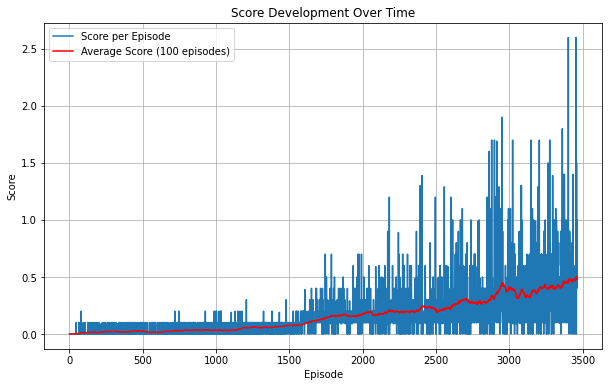

In [14]:
n_episodes = 5000
max_t = 1000
scores_deque = deque(maxlen=100)
scores = []
average_scores = []
global_step = 0

for i_episode in range(1, n_episodes + 1):
    env_info = env.reset(train_mode=True)[brain_name]
    states = env_info.vector_observations
    for agent in agents:
        agent.reset()
    score = np.zeros(num_agents)
    for t in range(max_t):
        actions = np.array([agent.act(states[i]) for i, agent in enumerate(agents)])
        env_info = env.step(actions)[brain_name]
        next_states = env_info.vector_observations
        rewards = env_info.rewards
        dones = env_info.local_done
        for i, agent in enumerate(agents):
            agent.step(states[i], actions[i], rewards[i], next_states[i], dones[i], global_step)
            global_step += 1
        states = next_states
        score += rewards
        if np.any(dones):
            break
    max_score = np.max(score)
    scores_deque.append(max_score)
    scores.append(max_score)
    average_scores.append(np.mean(scores_deque))  # Store the average score

    # Log the average score to TensorBoard
    # writer.add_scalar('average_score', np.mean(scores_deque), i_episode)

    print(f'\rEpisode {i_episode}\tAverage Score: {np.mean(scores_deque):.2f}', end="")
    if i_episode % 100 == 0:
        print(f'\rEpisode {i_episode}\tAverage Score: {np.mean(scores_deque):.2f}')
    if np.mean(scores_deque) >= 0.5:
        print(f'\nEnvironment solved in {i_episode} episodes!\tAverage Score: {np.mean(scores_deque):.2f}')
        for idx, agent in enumerate(agents):
            torch.save(agent.actor_local.state_dict(), f'checkpoint_actor_agent_1.{idx}.pth')
            torch.save(agent.critic_local.state_dict(), f'checkpoint_critic_agent_1.{idx}.pth')
        break

# Plotting the results
plt.figure(figsize=(10, 6))
plt.plot(np.arange(1, len(scores) + 1), scores, label='Score per Episode')
plt.plot(np.arange(1, len(average_scores) + 1), average_scores, label='Average Score (100 episodes)', color='r')
plt.xlabel('Episode')
plt.ylabel('Score')
plt.title('Score Development Over Time')
plt.legend()
plt.grid(True)
plt.show()

# Close TensorBoard writer
# writer.close()
